In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from google.colab import drive
import matplotlib.pyplot as plt

*Reference*: creating saliency map with tensorflow

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

def generate_saliency_map(image_path, model, target_layer_idx=-1, target_class_index=0):
    # Load the image and preprocess it
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Assuming VGG16 input size

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Convert the image data to a TensorFlow tensor
    x = tf.convert_to_tensor(x, dtype=tf.float32)

    # Define a model that outputs the activations of the target layer
    activation_model = Model(inputs=model.input, outputs=model.layers[target_layer_idx].output)

    # Compute the gradients of the target class with respect to the model's output
    with tf.GradientTape() as tape:
        tape.watch(x)
        activations = activation_model(x)
        class_output = activations[0][0, target_class_index]  # Assuming a single class output
    grads = tape.gradient(class_output, x)

    # Normalize the gradients
    grads /= (tf.reduce_max(tf.abs(grads)) + 1e-8)

    # Create a saliency map by averaging the absolute gradients across color channels
    saliency_map = np.mean(np.abs(grads[0].numpy()), axis=-1)

    return saliency_map

# Load a pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=True)

# Specify the path to the input image
image_path = 'path_to_your_image.jpg'

# Generate the saliency map
saliency_map = generate_saliency_map(image_path, model)

# Save or display the saliency map
cv2.imwrite('saliency_map.jpg', (saliency_map * 255).astype(np.uint8))


KeyboardInterrupt: ignored

# CNN-SVR


In [13]:
from google.colab import drive
drive_dir = '/content/drive'
drive.mount(drive_dir, force_remount=True)

Mounted at /content/drive


In [14]:
train_data_dir = 'My Drive/CSCI 2952G Final Project/cnn-svr_training_example.csv'
train_data_path = f"{drive_dir}/{train_data_dir}"

test_data_dir = 'My Drive/CSCI 2952G Final Project/cnn-svr_testing_example.csv'
test_data_path = f"{drive_dir}/{test_data_dir}"

weight_dir = 'My Drive/CSCI 2952G Final Project/cnn-svr_weights.h5'
weight_path = f"{drive_dir}/{weight_dir}"

train_data = pd.read_csv(train_data_path)
print(train_data.head())
test_data = pd.read_csv(test_data_path) # needs to be uploaded from you device
print(test_data.head())

    chr      start        end direction                      seq  \
0  chr1  166826820  166826842         -  CAGCGCTTGGCAGCCAAGGAGGG   
1  chr1  166826821  166826843         -  CCAGCGCTTGGCAGCCAAGGAGG   
2  chr1  166826824  166826846         +  CCTTGGCTGCCAAGCGCTGGCGG   
3  chr1  166826885  166826907         -  AAAGGATCATCACGAAACTCTGG   
4  chr1  166827398  166827420         +  AGATGCAGGTAGAGTGTCTCCGG   

                      ctcf                    dnase                  h3k4me3  \
0  AAAAAAAAAAAAAAAAAAAAAAA  AAAAAAAAAAAAAAAAAAAAAAA  NNNNNNNNNNNNNNNNNNNNNNN   
1  AAAAAAAAAAAAAAAAAAAAAAA  AAAAAAAAAAAAAAAAAAAAAAA  NNNNNNNNNNNNNNNNNNNNNNN   
2  AAAAAAAAAAAAAAAAAAAAANN  AAAAAAAAAAAAAAAAAAAAAAA  NNNNNNNNNNNNNNNNNNNNNNN   
3  NNNNNNNNNNNNNNNNNNNNNNN  AAAAAAAAAAAAAAAAAAAAAAA  NNNNNNNNNNNNNNNNNNNNNNN   
4  AAAAAAAAAAAAAAAAAAAAAAA  AAAAAAAAAAAAAAAAAAAAAAA  NNNNNNNNNNNNNNNNNNNNNNN   

                      rrbs  indel_frequency  
0  NNNNNNNNNNNNNNNNNNNNNNN         0.138509  
1  NNNNNNNNNNNNNNN

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution1D, AveragePooling1D
from tensorflow.keras.layers import concatenate

from sklearn.svm import SVR
import scipy.stats as stats


def grna_preprocess(lines):
    length = 23
    data_n = len(lines)
    seq = np.zeros((data_n, length, 4), dtype=int)
    for l in range(data_n):
        data = lines[l]
        seq_temp = data
        for i in range(length):
            if seq_temp[i] in "Aa":
                seq[l, i, 0] = 1
            elif seq_temp[i] in "Cc":
                seq[l, i, 1] = 1
            elif seq_temp[i] in "Gg":
                seq[l, i, 2] = 1
            elif seq_temp[i] in "Tt":
                seq[l, i, 3] = 1
    return seq


def epi_preprocess(lines):
    length = 23
    data_n = len(lines)
    epi = np.zeros((data_n, length), dtype=int)
    for l in range(data_n):
        data = lines[l]
        epi_temp = data
        for i in range(length):
            if epi_temp[i] in "A":
                epi[l, i] = 1
            elif epi_temp[i] in "N":
                epi[l, i] = 0
    return epi


def preprocess(file_path, usecols):
    data = pd.read_csv(file_path, usecols=usecols)
    data = np.array(data)
    ctcf, dnase, h3k4me3, rrbs = epi_preprocess(data[:, 0]), epi_preprocess(data[:, 1]), epi_preprocess(data[:, 2]), epi_preprocess(data[:, 3])
    epi = []
    for i in range(len(data)):
        ctcf_t, dnase_t, h3k4me3_t, rrbs_t = pd.DataFrame(ctcf[i]), pd.DataFrame(dnase[i]), pd.DataFrame(h3k4me3[i]), pd.DataFrame(rrbs[i])
        epi_t = pd.concat([ctcf_t, dnase_t, h3k4me3_t, rrbs_t], axis=1)
        epi_t = np.array(epi_t)
        epi.append(epi_t)
    epi = np.array(epi)
    return epi


def load_data(train_file, test_file):
    train_data = pd.read_csv(train_file, usecols=[4, 9])
    train_data = np.array(train_data)
    train_seq, train_y = train_data[:, 0], train_data[:, 1]
    train_seq = grna_preprocess(train_seq)
    train_epi = preprocess(train_file, [5, 6, 7, 8])
    train_y = train_y.reshape(len(train_y), -1)

    test_data = pd.read_csv(test_file, usecols=[4, 9])
    test_data = np.array(test_data)
    test_seq, test_y = test_data[:, 0], test_data[:, 1]
    test_seq = grna_preprocess(test_seq)
    test_epi = preprocess(test_file, [5, 6, 7, 8])
    test_y = test_y.reshape(len(test_y), -1)
    return train_seq, test_seq, train_epi, test_epi, train_y, test_y


# Build model
def build_model():
    dropout = 0.3
    seq_input = Input(shape=(23, 4))
    seq_conv1 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='seq_conv_1')(seq_input)
    seq_act1 = Activation('relu', name='seq_activation1')(seq_conv1)
    seq_pool1 = AveragePooling1D(2, name='seq_pooling_1')(seq_act1)
    seq_drop1 = Dropout(dropout)(seq_pool1)

    seq_conv2 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='seq_conv_2')(seq_drop1)
    seq_act2 = Activation('relu', name='seq_activation_2')(seq_conv2)
    seq_pool2 = AveragePooling1D(2, name='seq_pooling_2')(seq_act2)
    seq_drop2 = Dropout(dropout)(seq_pool2)
    seq_flat = Flatten()(seq_drop2)

    seq_dense1 = Dense(256, activation='relu', name='seq_dense_1')(seq_flat)
    seq_drop3 = Dropout(dropout)(seq_dense1)
    seq_dense2 = Dense(128, activation='relu', name='seq_dense_2')(seq_drop3)
    seq_drop4 = Dropout(dropout)(seq_dense2)
    seq_dense3 = Dense(64, activation='relu', name='seq_dense_3')(seq_drop4)
    seq_drop5 = Dropout(dropout)(seq_dense3)
    seq_out = Dense(40, activation='relu', name='seq_dense_4')(seq_drop5)

    epi_input = Input(shape=(23, 4))
    epi_conv1 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='epi_conv_1')(epi_input)
    epi_act1 = Activation('relu', name='epi_activation_1')(epi_conv1)
    epi_pool1 = AveragePooling1D(2, name='epi_pooling_1')(epi_act1)
    epi_drop1 = Dropout(dropout)(epi_pool1)

    epi_conv2 = Convolution1D(256, 5, kernel_initializer='glorot_uniform', name='epi_conv_2')(epi_drop1)
    epi_act2 = Activation('relu', name='epi_activation_2')(epi_conv2)
    epi_pool2 = AveragePooling1D(2, name='epi_pooling_2')(epi_act2)
    epi_drop2 = Dropout(dropout)(epi_pool2)
    epi_flat = Flatten()(epi_drop2)

    epi_dense1 = Dense(256, activation='relu', name='epi_dense_1')(epi_flat)
    epi_drop3 = Dropout(dropout)(epi_dense1)
    epi_dense2 = Dense(128, activation='relu', name='epi_dense_2')(epi_drop3)
    epi_drop4 = Dropout(dropout)(epi_dense2)
    epi_dense3 = Dense(64, activation='relu', name='epi_dense_3')(epi_drop4)
    epi_drop5 = Dropout(dropout)(epi_dense3)
    epi_out = Dense(40, activation='relu', name='epi_dense_4')(epi_drop5)

    merged = concatenate([seq_out, epi_out], axis=-1)

    model = Model(inputs=[seq_input, epi_input], outputs=[merged])

    # # Load weights for the model
    # print("Loading weights for the models")
    # model.load_weights(weight_path, by_name=True)

    # prediction = Dense(1, activation='linear', name='prediction')(merged)
    # final_model = Model([seq_input, epi_input], prediction)
    return model

Try out CNN-SVR

In [16]:
# Load weights for the model
print("Loading weights for the models")
model = build_model()
model.load_weights(weight_path, by_name = True)

# Load training and testing data
print("Loading training and testing data")
seq_train, seq_test, epi_train, epi_test, y_train, y_test = load_data(train_data_path, test_data_path)

# Training and testing data shape
print("training sequence data shape: " + str(seq_train.shape))
print("training epigenetic data shape: " + str(epi_train.shape))
print("testing sequence data shape: " + str(seq_test.shape))
print("testing epigenetic data shape: " + str(epi_test.shape))

# Predict on data
print("Predicting on training and testing data")
x_train = model.predict([seq_train, epi_train])
x_test = model.predict([seq_test, epi_test])

print("output (training) shape: " + str(x_train.shape))
print("output (testing) shape: " + str(x_test.shape))

x_train, x_test = np.array(x_train), np.array(x_test)

# Select important features from outputs of the CNN model
selected_cnn_fea_cols = [17, 26, 9, 19, 30, 6, 12, 39, 36, 21, 22, 3, 25]
x_train = x_train[:, selected_cnn_fea_cols]
x_test = x_test[:, selected_cnn_fea_cols]

print("training data shape: " + str(x_train.shape))
print("testing data shape: " + str(x_test.shape))

y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

# SVR model
clf = SVR(kernel="rbf", gamma=0.12, C=1.7, epsilon=0.11, verbose=1)
# Fit the SVR model according to the given training data
clf.fit(x_train, y_train)

# Perform regression on samples in x_train
y_pred_train = clf.predict(x_train)
# Perform regression on samples in x_test
y_pred = clf.predict(x_test)

# Output from SVR
print("prediction: " + str(y_pred))
print("target: " + str(y_test))

Loading weights for the models
Loading training and testing data
training sequence data shape: (3653, 23, 4)
training epigenetic data shape: (3653, 23, 4)
testing sequence data shape: (2, 23, 4)
testing epigenetic data shape: (2, 23, 4)
Predicting on training and testing data
1/1 [==============================] - 0s 37ms/step
output (training) shape: (3653, 80)
output (testing) shape: (2, 80)
training data shape: (3653, 13)
testing data shape: (2, 13)
[LibSVM]prediction: [0.22743429 0.32166103]
target: [0.382065546 0.191863287]


# Saliency Map

In [30]:
from tensorflow.keras.models import Model

def generate_saliency_map(seq_input, epi_input, model, target_layer_idx=-1):
    # Finds the target layer
    target_layer = Model(inputs=model.input, outputs=model.layers[target_layer_idx].output)

    # Compute the gradients of the target class with respect to the model's output
    seq = tf.convert_to_tensor(seq_input, dtype=tf.float32)
    epi = tf.convert_to_tensor(epi_input, dtype=tf.float32)
    with tf.GradientTape(persistent = True) as tape:
        tape.watch(seq)
        tape.watch(epi)
        output = target_layer([seq, epi])
        print("output shape: " + str(output.shape))

    # grads = [tape.gradient(output[:, i], [seq, epi]) for i in range(output.shape[1])]
    jacob_seq = tape.batch_jacobian(output, seq)
    jacob_epi = tape.batch_jacobian(output, epi)

    # Normalize the gradients
    jacob_seq /= (tf.reduce_max(tf.abs(jacob_seq)) + 1e-8)
    jacob_epi /= (tf.reduce_max(tf.abs(jacob_epi)) + 1e-8)
    print("jacobian seq shape: " + str(jacob_seq.shape))
    print("jacobian epi shape: " + str(jacob_epi.shape))


    # Clean up the persistent gradient tape
    del tape

    return jacob_seq, jacob_epi

saliency_map_seq, saliency_map_epi = generate_saliency_map(seq_train[:100], epi_train[:100], model)

model_output = model([seq_train[:100], epi_train[:100]])

print("Model outputs: " + str(model_output))
print("Sequence data saliency map shape: " + str(saliency_map_seq.shape))
print("Epigenetic data saliency map shape: " + str(saliency_map_epi.shape))


output shape: (100, 80)
jacobian seq shape: (100, 80, 23, 4)
jacobian epi shape: (100, 80, 23, 4)
Model outputs: tf.Tensor(
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.14169441 ... 0.         0.         0.        ]
 [0.         0.         0.14169441 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.14169441 ... 0.         0.         0.        ]
 [0.         0.         0.14169441 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]], shape=(100, 80), dtype=float32)
Sequence data saliency map shape: (100, 80, 23, 4)
Epigenetic data saliency map shape: (100, 80, 23, 4)


In [32]:
def count_nonzero(saliency_map):
    count = 0
    nonzero = []
    for i in range(len(saliency_map)):
        if np.any(saliency_map[i]):
            count += 1
            nonzero.append(i)
    return count, nonzero

print(str(count_nonzero(model_output)[0]) + " out of " + str(len(model_output))
+ " samples in the saliency map of the sequencial inputs are nonzero")
print(str(count_nonzero(saliency_map_seq)[0]) + " out of " + str(len(saliency_map_seq))
+ " samples in the saliency map of the sequencial inputs are nonzero")
print(str(count_nonzero(saliency_map_epi)[0]) + " out of " + str(len(saliency_map_epi))
+ " samples in the saliency map of the epigenetics inputs are nonzero")

66 out of 100 samples in the saliency map of the sequencial inputs are nonzero
3 out of 100 samples in the saliency map of the sequencial inputs are nonzero
0 out of 100 samples in the saliency map of the epigenetics inputs are nonzero
3653 out of 3653 samples in the original epigenetics inputs are nonzero


In [ ]:
def find_max(saliency_map):
    max = 0
    index = 0
    for i in range(len(saliency_map)):
        cur = np.sum(np.abs(np.array(saliency_map[i]).ravel()))
        if cur > max:
            max = cur
            index = i
    return max, index

_, max_index = find_max(saliency_map_seq)
print(max_index)

83


In [ ]:
num_map, map_list = count_nonzero(saliency_map_seq[max_index])

print(num_map)
print(map_list)

6
[2, 13, 17, 20, 23, 39]


In [ ]:
def draw_saliency_map(saliency_map, feature_num):
    # Normalize the saliency map to the range [0, 1]
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map) + 1e-8)

    # Transpose the map to match the format in the paper
    saliency_map = np.transpose(saliency_map)

    # Create a heatmap by applying a colormap (e.g., 'viridis')
    heatmap = plt.get_cmap('viridis')(saliency_map)

    # Display the original image, saliency map, and overlaid image
    plt.figure(figsize=(12, 6))
    plt.imshow(saliency_map, cmap='viridis')
    plt.colorbar()

    plt.title('Saliency Map for Feature ' + str(feature_num))
    y_ticks = np.arange(0, 4, 1)  # Custom tick locations
    y_tick_labels = ['A', 'C', 'G', 'T']  # Custom tick labels

    x_ticks = np.arange(0, 23, 1)  # Custom tick locations
    x_tick_labels = np.arange(1, 24, 1)  # Custom tick labels

    plt.xticks(x_ticks, x_tick_labels)
    plt.yticks(y_ticks, y_tick_labels)

    plt.xlabel('Genomic Position')
    plt.ylabel('Nucleotide')

    plt.show()

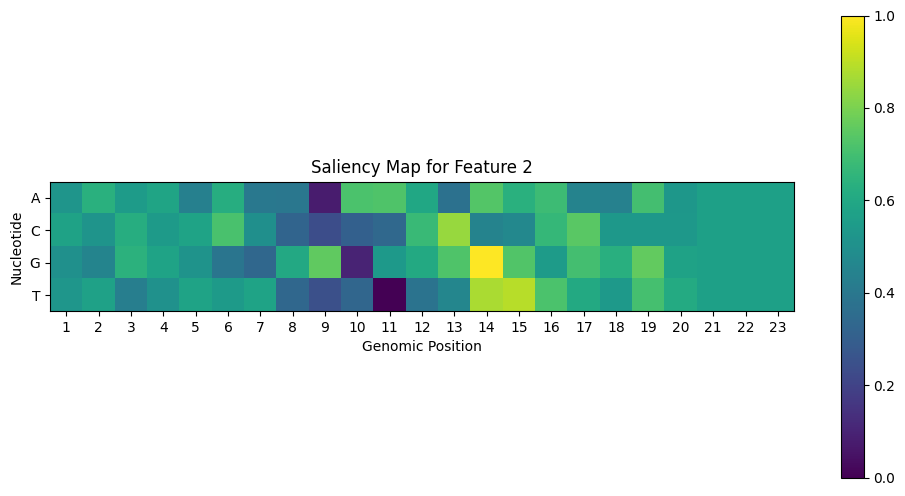

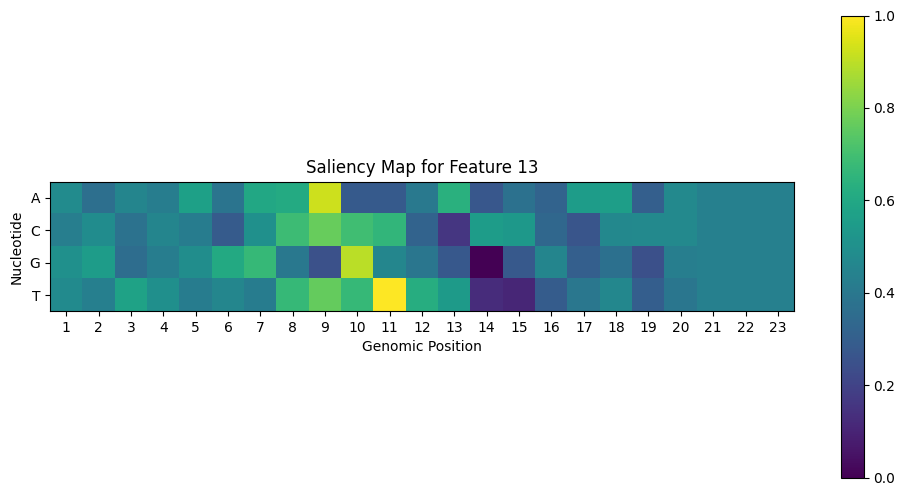

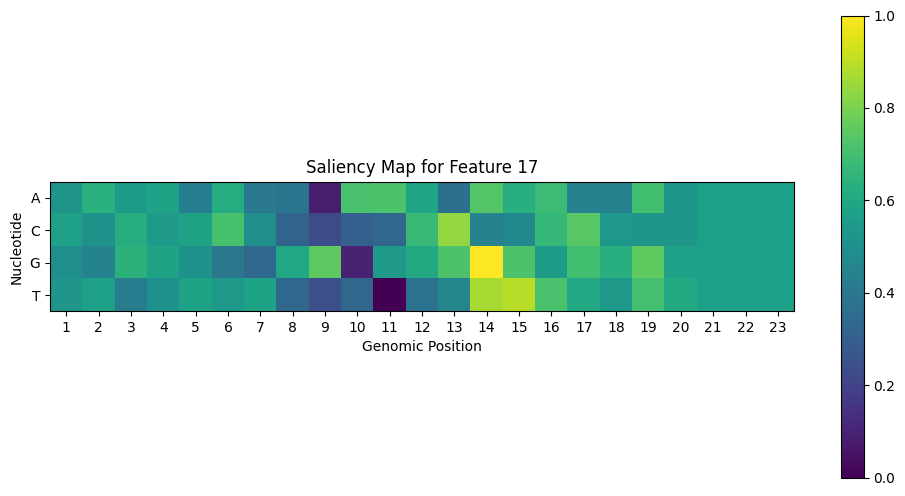

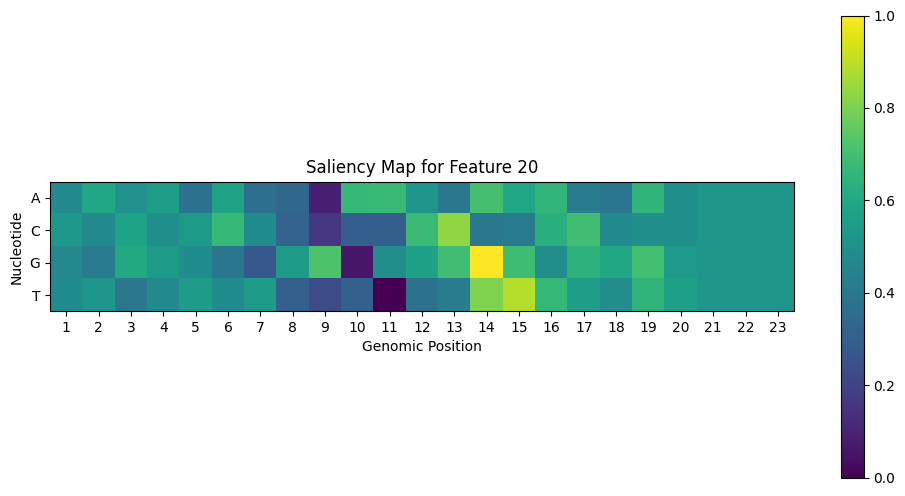

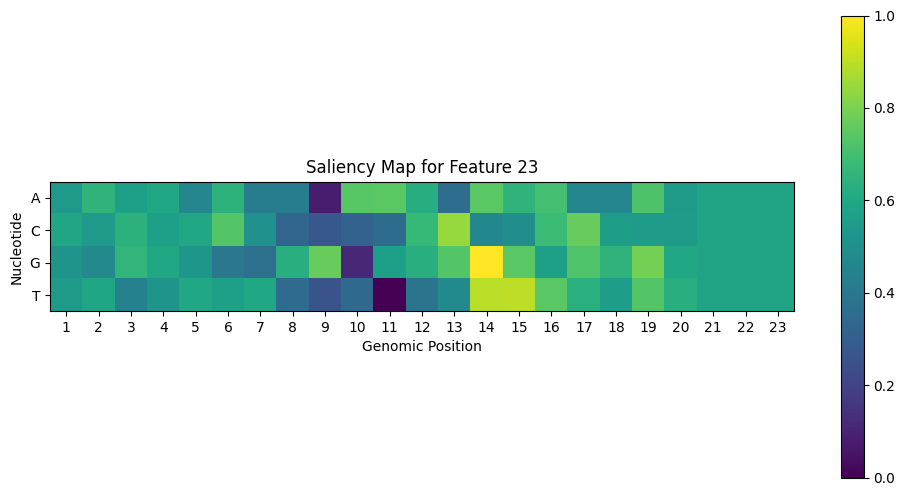

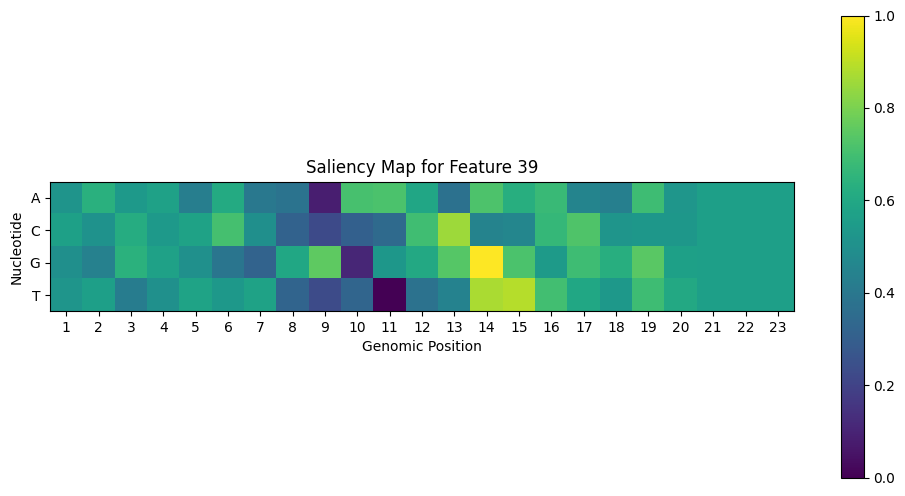

In [ ]:
draw_saliency_map(x_, "Input")
for i in map_list:
  draw_saliency_map(saliency_map_seq[max_index][i], i)

# SVR Visualization

PCA on the output from CNN (2D)

In [ ]:
from sklearn.decomposition import PCA

pca_2 = PCA(n_components=2)

print(x_train.shape)
compressed_train = pca_2.fit_transform(x_train)
print(compressed_train.shape)


(3653, 13)
(3653, 2)


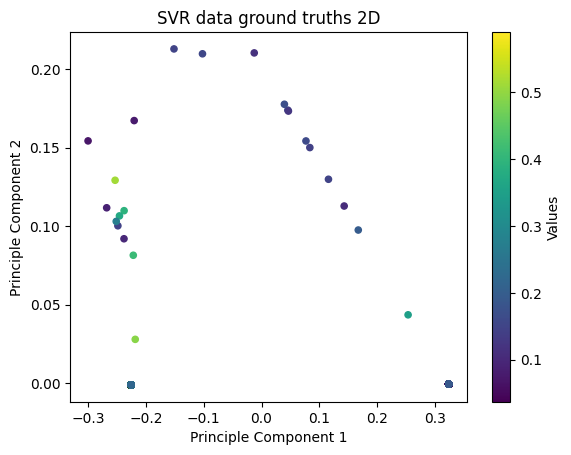

In [ ]:
x1 = compressed_train[:,0]
x2 = compressed_train[:,1]

# Create a scatter plot with colors based on values
plt.scatter(x1, x2, c=y_train, cmap='viridis', marker='o', s=20)

# Add a colorbar for reference
plt.colorbar(label='Values')

# Set labels and title
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('SVR data ground truths 2D')

# Show the plot
plt.show()

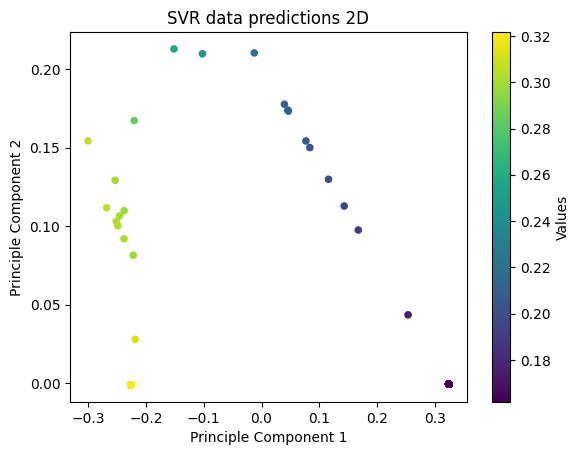

In [ ]:
x1 = compressed_train[:,0]
x2 = compressed_train[:,1]

# Create a scatter plot with colors based on values
plt.scatter(x1, x2, c=y_pred_train, cmap='viridis', marker='o', s=20)

# Add a colorbar for reference
plt.colorbar(label='Values')

# Set labels and title
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('SVR data predictions 2D')

# Show the plot
plt.show()

PCA on the output from CNN (1D)

In [ ]:
pca_1 = PCA(n_components=1)

print(x_train.shape)
compressed_train_1d = pca_1.fit_transform(x_train)
print(compressed_train_1d.shape)

print(x_test.shape)
compressed_test_1d = pca_1.fit_transform(x_test)
print(compressed_test_1d.shape)


(3653, 13)
(3653, 1)
(2, 13)
(2, 1)


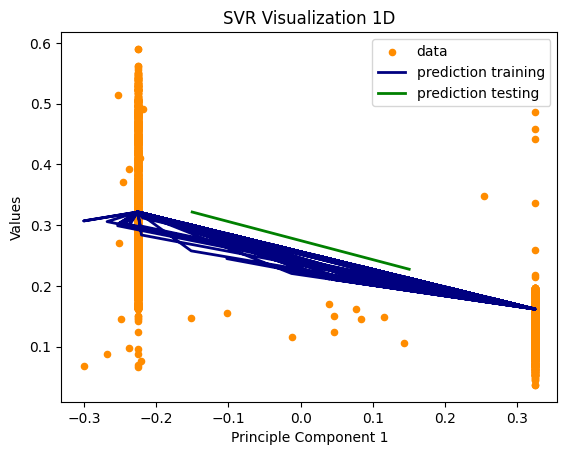

In [ ]:
# Plot the results
plt.scatter(compressed_train_1d, y_train, color='darkorange', marker='o', s=20, label='data')
plt.plot(compressed_train_1d, y_pred_train, color='navy', lw=2, label='prediction training')
plt.plot(compressed_test_1d, y_pred, color='green', lw=2, label='prediction testing')

plt.xlabel('Principle Component 1')
plt.ylabel('Values')
plt.title('SVR Visualization 1D')
plt.legend()
plt.show()

# SHAP VALUE

In [ ]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.3 MB/s eta 0:00:00


In [ ]:
pip install --upgrade shap scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import shap

In [ ]:
# Original SVR is not callable
svr_model_callable = callable(clf)
print(svr_model_callable)

False


In [ ]:
# Make it callable
class SVRWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)

svr_model = SVRWrapper(clf)

In [ ]:
# Original SVR is not callable
svr_model_callable = callable(svr_model)
print(svr_model_callable)

True


PermutationExplainer explainer: 3it [00:14,  7.41s/it]               


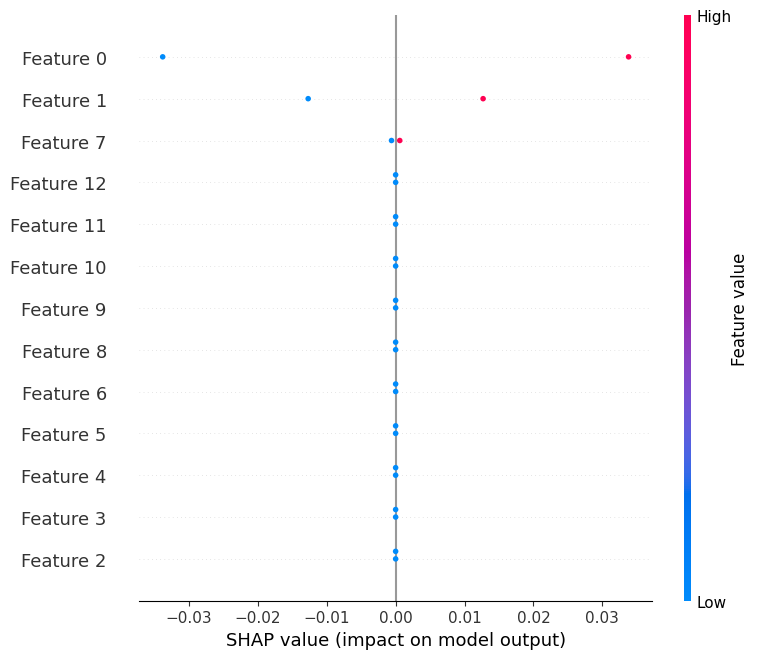

In [ ]:
shap.initjs()
explainer = shap.Explainer(svr_model, x_test)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)